In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../..'))

In [2]:
from spark.super_simulation import SuperSimulation
from spark.incarceration_transitions import IncarceratedTransitions
from spark.release_transitions import ReleasedTransitions
from spark.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml

/Users/justine/.local/share/virtualenvs/recidiviz-research--v7DE6HN/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


initialization time:  0.01235198974609375
simulation_time:  5.541782855987549


(             felony
 time_step          
 2011.000000       0
 2011.083333       0
 2011.166667       0
 2011.250000       0
 2011.333333       0
 ...             ...
 2018.583333       0
 2018.666667       0
 2018.750000       0
 2018.833333       0
 2018.916667       0
 
 [96 rows x 1 columns],
              felony
 probation  0.799664)

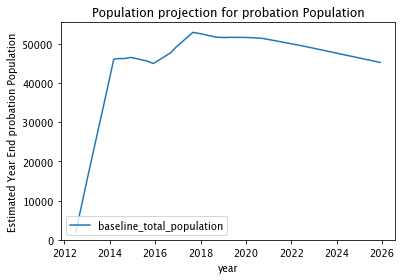

In [3]:
test = open('../state/MI/MI_parole_model_inputs.yaml')
test_sim = SuperSimulation(test)
test_sim.simulate_baseline('prison_shell', 'probation')

initialization time:  0.010161876678466797
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7341825559266042]
0.7341825559266042
simulation_time:  5.682897090911865
initialization time:  0.007729768753051758
simulation_time:  6.093707084655762


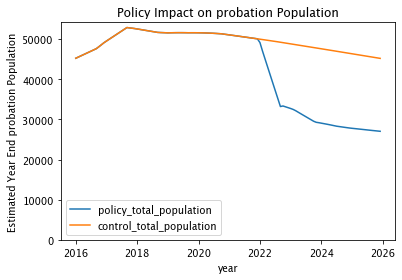

In [4]:
def apply_reduced_probation_cap(crime_type, retroactive=True):
    return partial(IncarceratedTransitions.apply_supervision_cap_reduction_MI, 
                   supervision_period_reduction=0.4, retroactive=retroactive)

policy_list_non_retroactive = [
    SparkPolicy(policy_fn=apply_reduced_probation_cap('felony', False),
                spark_compartment='probation',
                sub_population={'crime_type': 'felony'},
                apply_retroactive=False)
]

policy_list_retroactive = [
    SparkPolicy(policy_fn=apply_reduced_probation_cap('felony'),
                spark_compartment='probation',
                sub_population={'crime_type': 'felony'},
                apply_retroactive=True)
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'probation')

In [5]:
simulation_tag = 'MI_1050'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

/Users/justine/.local/share/virtualenvs/recidiviz-research--v7DE6HN/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [12]:
a, b = test_results
a.to_csv('MI_1050_spending_diff.csv')
b.to_csv('MI_1050_life_months_of_saved.csv')
test_sim.output_data['policy_simulation'].to_csv('MI_1050_total_populations')

In [15]:
test_sim.pop_simulations['policy'].sub_simulations['felony'].simulation_compartments['probation'].transition_tables.transition_dfs

{'before':       prison  prison_technicals   release  death  remaining
 1   0.000000           0.000000  0.000000  0.000        1.0
 2   0.000000           0.000000  0.000000  0.000        1.0
 3   0.000000           0.000000  0.000000  0.000        1.0
 4   0.000000           0.000000  0.000000  0.000        1.0
 5   0.000000           0.000000  0.000000  0.000        1.0
 6   0.000000           0.000000  0.000000  0.000        1.0
 7   0.000000           0.000000  0.000000  0.000        1.0
 8   0.000000           0.000000  0.000000  0.000        1.0
 9   0.000000           0.000000  0.000000  0.000        1.0
 10  0.000000           0.000000  0.000000  0.000        1.0
 11  0.000000           0.000000  0.000000  0.000        1.0
 12  0.000000           0.000000  0.000000  0.000        1.0
 13  0.000000           0.000000  0.000000  0.000        1.0
 14  0.000000           0.000000  0.000000  0.000        1.0
 15  0.000000           0.000000  0.000000  0.000        1.0
 16  0.000000 

In [28]:
a['probation'] = a.probation * (1 + ( (0.119291 * 9 / 21)))
b['probation'] = b.probation * (1 + ( (0.119291 * 9 / 21)))

In [32]:
a

,prison,release,prison_technicals,probation
year,,,,
2016.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2016.083333,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2016.166667,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2016.250000,0.000000e+00,0.0,0.000000e+00,0.000000e+00
2016.333333,0.000000e+00,0.0,0.000000e+00,0.000000e+00
...,...,...,...,...
2025.583333,3.029724e+06,0.0,-8.980683e+06,-3.024036e+08
2025.666667,2.481215e+06,0.0,-9.249246e+06,-3.083971e+08
2025.750000,1.885919e+06,0.0,-9.517224e+06,-3.143774e+08
